In [ ]:
pip install yf

ERROR: Operation cancelled by user


### *using yfinance library (has data from yahoo finance API) to fetch data *

In [1]:
import yfinance as yf
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GridSearchCV


In [2]:
df = yf.download('BTC-USD')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-11-04,34736.324219,35256.031250,34616.691406,35082.195312,35082.195312,9561294264
2023-11-05,35090.011719,35340.339844,34594.242188,35049.355469,35049.355469,12412743996
2023-11-06,35044.789062,35286.027344,34765.363281,35037.371094,35037.371094,12693436420


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler

### filter the dataframe as we are interested only in the date and close value

In [4]:
df.shape
df = df.reset_index(drop=False)
df = df[['Date','Close']]
df.head()

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


From the data from yfinace , Bitcoin price has a wide range of values by  ensuring that all features are on a similar scale. deep learning can converge faster and perform better




In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [6]:
df.head()

,Date,Close
0,2014-09-17,0.004144
1,2014-09-18,0.003655
2,2014-09-19,0.003216
3,2014-09-20,0.003425
4,2014-09-21,0.003275


### changing the date field type to pandas datetype

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

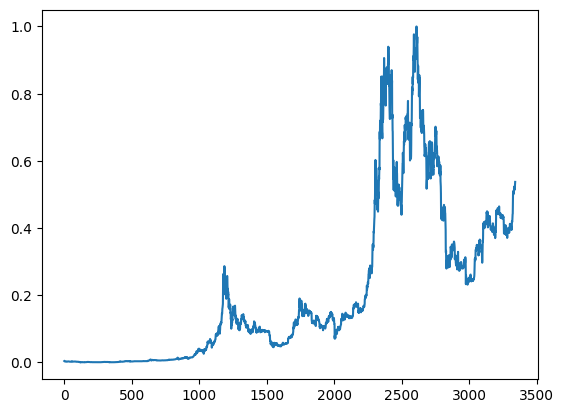

In [8]:
timeseries = df[["Close"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

### train-test split for time series

In [ ]:

train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size

train, test = timeseries[:train_size], timeseries[train_size:]


In [ ]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []

    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
def plot_predictions(best_model, X_train, y_train, X_test, y_test, timeseries, lookback, train_size):
    with torch.no_grad():
        # Calculate RMSE for training and test sets
        y_pred_train = best_model(X_train)
        y_pred_test = best_model(X_test)

        # Create arrays to store the predicted values for plotting
        train_plot = np.ones_like(timeseries) * np.nan
        train_plot[lookback:train_size] = y_pred_train[:, -1, :]

        test_plot = np.ones_like(timeseries) * np.nan
        test_plot[train_size + lookback:len(timeseries)] = y_pred_test[:, -1, :]

        # Plot the timeseries, training predictions (in red), and test predictions (in green)
        plt.plot(timeseries, c='b')
        plt.plot(train_plot, c='r')
        plt.plot(test_plot, c='g')
        plt.show()

In [ ]:
def train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,best_model_key):
    best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)

            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 100 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
            print("train RMSE %.4f, test RMSE %.4f" % (train_rmse, test_rmse))
            # Check if the current test RMSE is the best so far
            if test_rmse < best_test_rmse:
                print(test_rmse)
                best_test_rmse = test_rmse
                # Save the current model as the best model
                torch.save(model.state_dict(),best_model_key )

In [ ]:
def train_and_save_best_model_rnn(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,best_model_key):
  best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE


  for epoch in range(n_epochs):
      model.train()
      for X_batch, y_batch in loader:
          y_pred = model(X_batch.view(-1, lookback, 1).float())  # Adjust the input shape
          loss = loss_fn(y_pred, y_batch.view(-1, 1).float())  # Adjust the target shape and data type
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # Validation
      if epoch % 500 == 0:
          model.eval()
          with torch.no_grad():
              y_pred = model(X_train.view(-1, lookback, 1).float())  # Adjust the input shape
              train_rmse = torch.sqrt(loss_fn(y_pred, y_train.view(-1, 1).float()))  # Adjust the target shape and data type
    # Adjust the target shape and data type
              y_pred = model(X_test.view(-1, lookback, 1).float())  # Adjust the input shape
              test_rmse = torch.sqrt(loss_fn(y_pred, y_test.view(-1, 1).float()))  # Adjust the target shape and data type

              if test_rmse < best_test_rmse:
                  best_test_rmse = test_rmse
                  # Save the current model as the best model
                  best_model = model.state_dict()


###creating a lookback window of size 3- best model with batch size 100

In [ ]:
lookback = 3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2234, 3, 1]) torch.Size([2234, 3, 1])
torch.Size([1100, 3, 1]) torch.Size([1100, 3, 1])


RNN Model

In [ ]:
# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        print(output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
       # out = self.fc(out[-1, 2, -1])  # Only use the last output
        return out

Model with hidden_size: 50,n_epochs: 1000, lookback:3

In [ ]:
# Hyperparameters
input_size = 1  # Number of features (only "Close" in this example)
hidden_size = 50
output_size = 1  # Predicting "Close" value
learning_rate = 0.001

# Create the model and define loss and optimizer
model = SimpleRNN()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs = 1000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_rnn_model.pth')

1
train RMSE 0.1112, test RMSE 0.5236
tensor(0.5236)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 3, 1])) that is different to the input size (torch.Size([100, 3, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 3, 1])) that is different to the input size (torch.Size([32, 3, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train RMSE 0.0083, test RMSE 0.0998
tensor(0.0998)
train RMSE 0.0047, test RMSE 0.0747
tensor(0.0747)
train RMSE 0.0043, test RMSE 0.0713
tensor(0.0713)
train RMSE 0.0043, test RMSE 0.0726
train RMSE 0.0044, test RMSE 0.0709
tensor(0.0709)
train RMSE 0.0045, test RMSE 0.0730
train RMSE 0.0042, test RMSE 0.0721
train RMSE 0.0043, test RMSE 0.0720
train RMSE 0.0045, test RMSE 0.0708
tensor(0.0708)


Model with hidden_size: 100,n_epochs: 2000, lookback:3

In [ ]:
# Hyperparameters
input_size = 1  # Number of features (only "Close" in this example)
hidden_size = 100
output_size = 1  # Predicting "Close" value
num_epochs = 2000
learning_rate = 0.001

# Create the model and define loss and optimizer
model = SimpleRNN()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs = 1000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_rnn_model.pth')

1
train RMSE 0.0853, test RMSE 0.4971
tensor(0.4971)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 3, 1])) that is different to the input size (torch.Size([100, 3, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 3, 1])) that is different to the input size (torch.Size([32, 3, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train RMSE 0.0086, test RMSE 0.1034
tensor(0.1034)
train RMSE 0.0043, test RMSE 0.0746
tensor(0.0746)
train RMSE 0.0054, test RMSE 0.0749
train RMSE 0.0043, test RMSE 0.0715
tensor(0.0715)
train RMSE 0.0048, test RMSE 0.0743
train RMSE 0.0043, test RMSE 0.0721
train RMSE 0.0044, test RMSE 0.0723
train RMSE 0.0046, test RMSE 0.0744
train RMSE 0.0043, test RMSE 0.0718


In [ ]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2230, 7, 1]) torch.Size([2230, 7, 1])
torch.Size([1096, 7, 1]) torch.Size([1096, 7, 1])


Model with hidden_size: 50,n_epochs: 1000, lookback:7

In [ ]:
# Hyperparameters
input_size = 1  # Number of features (only "Close" in this example)
hidden_size = 50
output_size = 1  # Predicting "Close" value
learning_rate = 0.001

# Create the model and define loss and optimizer
model = SimpleRNN()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs = 1000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_rnn_model.pth')

1
train RMSE 0.0915, test RMSE 0.4800
tensor(0.4800)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 7, 1])) that is different to the input size (torch.Size([100, 7, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30, 7, 1])) that is different to the input size (torch.Size([30, 7, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2230, 7, 1])) that is different to the input size (torch.Size([2230, 7, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the s

train RMSE 0.0092, test RMSE 0.1039
tensor(0.1039)
train RMSE 0.0043, test RMSE 0.0743
tensor(0.0743)
train RMSE 0.0042, test RMSE 0.0717
tensor(0.0717)
train RMSE 0.0042, test RMSE 0.0716
tensor(0.0716)
train RMSE 0.0042, test RMSE 0.0721
train RMSE 0.0044, test RMSE 0.0708
tensor(0.0708)
train RMSE 0.0042, test RMSE 0.0715
train RMSE 0.0042, test RMSE 0.0717
train RMSE 0.0047, test RMSE 0.0768


Model with hidden_size: 100,n_epochs: 2000, lookback:7

In [ ]:
# Hyperparameters
input_size = 1  # Number of features (only "Close" in this example)
hidden_size = 50
output_size = 1  # Predicting "Close" value
learning_rate = 0.001

# Create the model and define loss and optimizer
model = SimpleRNN()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=1000)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs = 1000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_rnn_model.pth')

1
train RMSE 0.1375, test RMSE 0.5202
tensor(0.5202)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000, 7, 1])) that is different to the input size (torch.Size([1000, 7, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([230, 7, 1])) that is different to the input size (torch.Size([230, 7, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train RMSE 0.0280, test RMSE 0.2224
tensor(0.2224)
train RMSE 0.0218, test RMSE 0.1867
tensor(0.1867)
train RMSE 0.0183, test RMSE 0.1637
tensor(0.1637)
train RMSE 0.0158, test RMSE 0.1479
tensor(0.1479)
train RMSE 0.0137, test RMSE 0.1343
tensor(0.1343)
train RMSE 0.0118, test RMSE 0.1225
tensor(0.1225)
train RMSE 0.0101, test RMSE 0.1122
tensor(0.1122)
train RMSE 0.0086, test RMSE 0.1042
tensor(0.1042)
train RMSE 0.0073, test RMSE 0.0959
tensor(0.0959)


Model with hidden_size: 1000,n_epochs: 2000, lookback:7

In [ ]:
best_model = SimpleRNN() # Create an instance of your model
best_model.load_state_dict(torch.load('best_rnn_model.pth'))

1


<All keys matched successfully>

 **LSTM Model**

In [ ]:
class Temperature_LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
class Temperature_LSTM_Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(100, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
class Temperature_LSTM_Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=1000, num_layers=1, batch_first=True)
        self.linear = nn.Linear(1000, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
lookback = 3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2234, 3, 1]) torch.Size([2234, 3, 1])
torch.Size([1100, 3, 1]) torch.Size([1100, 3, 1])


Model with hidden_size: 50,n_epochs: 1000, lookback:3

In [ ]:
model = Temperature_LSTM_Model()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs=1000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_model.pth')

train RMSE 0.0698, test RMSE 0.4529
tensor(0.4529)
train RMSE 0.0042, test RMSE 0.0290
tensor(0.0290)
train RMSE 0.0044, test RMSE 0.0342
train RMSE 0.0042, test RMSE 0.0363
train RMSE 0.0045, test RMSE 0.0377
train RMSE 0.0045, test RMSE 0.0377
train RMSE 0.0042, test RMSE 0.0419
train RMSE 0.0043, test RMSE 0.0412
train RMSE 0.0044, test RMSE 0.0396
train RMSE 0.0042, test RMSE 0.0434


Model with hidden_size: 100,n_epochs: 2000, lookback window size:3

In [ ]:
model = Temperature_LSTM_Model_2()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100) # Initialize a variable to keep track of the best test RMSE
n_epochs=2000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_model.pth')

train RMSE 0.0693, test RMSE 0.4564
tensor(0.4564)
train RMSE 0.0043, test RMSE 0.0321
tensor(0.0321)
train RMSE 0.0043, test RMSE 0.0356
train RMSE 0.0044, test RMSE 0.0317
tensor(0.0317)
train RMSE 0.0045, test RMSE 0.0372
train RMSE 0.0044, test RMSE 0.0366
train RMSE 0.0042, test RMSE 0.0391
train RMSE 0.0043, test RMSE 0.0404
train RMSE 0.0042, test RMSE 0.0391
train RMSE 0.0043, test RMSE 0.0417
train RMSE 0.0042, test RMSE 0.0444
train RMSE 0.0042, test RMSE 0.0435
train RMSE 0.0042, test RMSE 0.0427
train RMSE 0.0042, test RMSE 0.0443
train RMSE 0.0042, test RMSE 0.0426
train RMSE 0.0043, test RMSE 0.0472
train RMSE 0.0042, test RMSE 0.0460
train RMSE 0.0042, test RMSE 0.0465
train RMSE 0.0046, test RMSE 0.0477
train RMSE 0.0042, test RMSE 0.0467


In [ ]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2230, 7, 1]) torch.Size([2230, 7, 1])
torch.Size([1095, 7, 1]) torch.Size([1095, 7, 1])


Model with hidden_size: 50,n_epochs: 1000, lookback window size:7

In [ ]:
model = Temperature_LSTM_Model()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs=1000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_model.pth')

train RMSE 0.0584, test RMSE 0.4471
tensor(0.4471)
train RMSE 0.0042, test RMSE 0.0343
tensor(0.0343)
train RMSE 0.0047, test RMSE 0.0371
train RMSE 0.0044, test RMSE 0.0375
train RMSE 0.0042, test RMSE 0.0390
train RMSE 0.0042, test RMSE 0.0397
train RMSE 0.0042, test RMSE 0.0442
train RMSE 0.0042, test RMSE 0.0405
train RMSE 0.0043, test RMSE 0.0430
train RMSE 0.0042, test RMSE 0.0455


Model with hidden_size: 100,n_epochs: 2000, lookback window size:7

In [ ]:
model = Temperature_LSTM_Model_2()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs=2000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_model.pth')

train RMSE 0.0586, test RMSE 0.4472
tensor(0.4472)
train RMSE 0.0042, test RMSE 0.0346
tensor(0.0346)
train RMSE 0.0043, test RMSE 0.0343
tensor(0.0343)
train RMSE 0.0042, test RMSE 0.0374
train RMSE 0.0043, test RMSE 0.0393
train RMSE 0.0047, test RMSE 0.0352
train RMSE 0.0043, test RMSE 0.0431
train RMSE 0.0042, test RMSE 0.0414
train RMSE 0.0043, test RMSE 0.0434
train RMSE 0.0042, test RMSE 0.0457
train RMSE 0.0042, test RMSE 0.0471
train RMSE 0.0042, test RMSE 0.0497
train RMSE 0.0043, test RMSE 0.0540
train RMSE 0.0042, test RMSE 0.0556
train RMSE 0.0042, test RMSE 0.0584
train RMSE 0.0043, test RMSE 0.0611
train RMSE 0.0043, test RMSE 0.0619
train RMSE 0.0046, test RMSE 0.0634
train RMSE 0.0043, test RMSE 0.0673
train RMSE 0.0042, test RMSE 0.0728


In [ ]:
best_model = Temperature_LSTM_Model()  # Create an instance of your model
best_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

Model with hidden_size: 1000,n_epochs: 2000, lookback window size:7

In [ ]:
model = Temperature_LSTM_Model_3()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs=2000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_model.pth')

train RMSE 0.0533, test RMSE 0.4030
tensor(0.4030)
train RMSE 0.0048, test RMSE 0.0281
tensor(0.0281)
train RMSE 0.0042, test RMSE 0.0364
train RMSE 0.0043, test RMSE 0.0326
train RMSE 0.0043, test RMSE 0.0335
train RMSE 0.0044, test RMSE 0.0313
train RMSE 0.0043, test RMSE 0.0346
train RMSE 0.0045, test RMSE 0.0401
train RMSE 0.0044, test RMSE 0.0329
train RMSE 0.0046, test RMSE 0.0319


In [ ]:
with torch.no_grad():
        y_pred = best_model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = best_model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("train RMSE %.4f, test RMSE %.4f" % (train_rmse, test_rmse))

In [ ]:
best_model = Temperature_LSTM_Model()  # Create an instance of your model
best_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

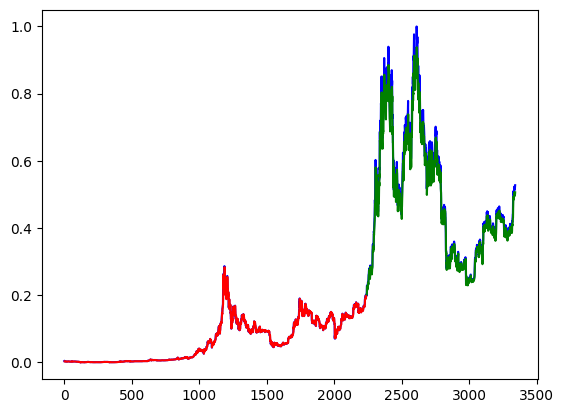

In [ ]:
plot_predictions(best_model, X_train, y_train, X_test, y_test, timeseries, lookback, train_size)

**GRU MODEL**

In [ ]:
class Temperature_GRUModel(nn.Module):
    def __init__(self):
        super().__init__()  # Corrected: Add parentheses here
        self.gru = nn.GRU(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

In [ ]:
class Temperature_GRUModel_2(nn.Module):
    def __init__(self):
        super().__init__()  # Corrected: Add parentheses here
        self.gru = nn.GRU(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(100, 1)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

In [ ]:
class Temperature_GRUModel_3(nn.Module):
    def __init__(self):
        super().__init__()  # Corrected: Add parentheses here
        self.gru = nn.GRU(input_size=1, hidden_size=1000, num_layers=1, batch_first=True)
        self.linear = nn.Linear(1000, 1)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

In [ ]:
lookback = 3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2234, 3, 1]) torch.Size([2234, 3, 1])
torch.Size([1100, 3, 1]) torch.Size([1100, 3, 1])


Model with hidden_size: 50,n_epochs: 1000, lookback:3

In [ ]:
model = Temperature_GRUModel()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs=1000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_model_gru.pth')

train RMSE 0.0619, test RMSE 0.4463
tensor(0.4463)
train RMSE 0.0043, test RMSE 0.0263
tensor(0.0263)
train RMSE 0.0043, test RMSE 0.0337
train RMSE 0.0042, test RMSE 0.0357
train RMSE 0.0045, test RMSE 0.0381
train RMSE 0.0043, test RMSE 0.0408
train RMSE 0.0043, test RMSE 0.0387
train RMSE 0.0046, test RMSE 0.0373
train RMSE 0.0042, test RMSE 0.0429
train RMSE 0.0043, test RMSE 0.0420


Model with hidden_size: 100,n_epochs: 2000, lookback window size:3

In [ ]:
model = Temperature_GRUModel_2()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs=2000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_model_gru.pth')

train RMSE 0.0538, test RMSE 0.4011
tensor(0.4011)
train RMSE 0.0043, test RMSE 0.0264
tensor(0.0264)
train RMSE 0.0042, test RMSE 0.0323
train RMSE 0.0044, test RMSE 0.0365
train RMSE 0.0044, test RMSE 0.0363
train RMSE 0.0042, test RMSE 0.0358
train RMSE 0.0042, test RMSE 0.0359
train RMSE 0.0045, test RMSE 0.0375
train RMSE 0.0042, test RMSE 0.0368
train RMSE 0.0042, test RMSE 0.0399
train RMSE 0.0043, test RMSE 0.0425
train RMSE 0.0043, test RMSE 0.0412
train RMSE 0.0043, test RMSE 0.0371
train RMSE 0.0043, test RMSE 0.0450
train RMSE 0.0043, test RMSE 0.0418
train RMSE 0.0042, test RMSE 0.0476
train RMSE 0.0042, test RMSE 0.0470
train RMSE 0.0045, test RMSE 0.0491
train RMSE 0.0042, test RMSE 0.0555
train RMSE 0.0042, test RMSE 0.0579


In [ ]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2228, 7, 1]) torch.Size([2228, 7, 1])
torch.Size([1095, 7, 1]) torch.Size([1095, 7, 1])


Model with hidden_size: 50,n_epochs: 1000, lookback:7

In [ ]:
model = Temperature_GRUModel()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs=1000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_model_gru.pth')

train RMSE 0.0631, test RMSE 0.4386
tensor(0.4386)
train RMSE 0.0042, test RMSE 0.0250
tensor(0.0250)
train RMSE 0.0043, test RMSE 0.0312
train RMSE 0.0043, test RMSE 0.0362
train RMSE 0.0043, test RMSE 0.0365
train RMSE 0.0042, test RMSE 0.0341
train RMSE 0.0042, test RMSE 0.0367
train RMSE 0.0043, test RMSE 0.0344
train RMSE 0.0043, test RMSE 0.0352
train RMSE 0.0042, test RMSE 0.0360


Model with hidden_size: 100,n_epochs: 2000, lookback window size:3

In [ ]:
model = Temperature_GRUModel_2()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs=2000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_model_gru.pth')

train RMSE 0.0574, test RMSE 0.4294
tensor(0.4294)
train RMSE 0.0044, test RMSE 0.0258
tensor(0.0258)
train RMSE 0.0045, test RMSE 0.0314
train RMSE 0.0043, test RMSE 0.0320
train RMSE 0.0043, test RMSE 0.0339
train RMSE 0.0042, test RMSE 0.0370
train RMSE 0.0042, test RMSE 0.0365
train RMSE 0.0045, test RMSE 0.0407
train RMSE 0.0043, test RMSE 0.0370
train RMSE 0.0043, test RMSE 0.0395
train RMSE 0.0043, test RMSE 0.0364
train RMSE 0.0042, test RMSE 0.0381
train RMSE 0.0042, test RMSE 0.0385
train RMSE 0.0043, test RMSE 0.0400
train RMSE 0.0043, test RMSE 0.0432
train RMSE 0.0042, test RMSE 0.0452
train RMSE 0.0042, test RMSE 0.0465
train RMSE 0.0043, test RMSE 0.0484
train RMSE 0.0043, test RMSE 0.0481
train RMSE 0.0042, test RMSE 0.0572


Model with hidden_size: 1000,n_epochs: 2000, lookback window size:7

In [ ]:
model = Temperature_GRUModel_3()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=100)
best_test_rmse = float('inf')  # Initialize a variable to keep track of the best test RMSE
best_model = None  # Initialize a variable to store the best model
n_epochs=2000
train_and_save_best_model(model, optimizer, loss_fn, loader, X_train, y_train, X_test, y_test, n_epochs,'best_model_gru.pth')

train RMSE 0.0416, test RMSE 0.2795
tensor(0.2795)
train RMSE 0.0043, test RMSE 0.0337
tensor(0.0337)
train RMSE 0.0043, test RMSE 0.0366
train RMSE 0.0042, test RMSE 0.0296
tensor(0.0296)
train RMSE 0.0043, test RMSE 0.0350
train RMSE 0.0043, test RMSE 0.0395
train RMSE 0.0043, test RMSE 0.0391
train RMSE 0.0043, test RMSE 0.0337
train RMSE 0.0045, test RMSE 0.0402
train RMSE 0.0043, test RMSE 0.0390
train RMSE 0.0043, test RMSE 0.0391
train RMSE 0.0042, test RMSE 0.0434
train RMSE 0.0043, test RMSE 0.0459
train RMSE 0.0042, test RMSE 0.0458
train RMSE 0.0043, test RMSE 0.0583
train RMSE 0.0043, test RMSE 0.0601
train RMSE 0.0042, test RMSE 0.0762
train RMSE 0.0042, test RMSE 0.0912
train RMSE 0.0042, test RMSE 0.0997
train RMSE 0.0042, test RMSE 0.1028


In [ ]:
best_model = Temperature_GRUModel()  # Create an instance of your model
best_model.load_state_dict(torch.load('best_model_gru.pth'))

<All keys matched successfully>

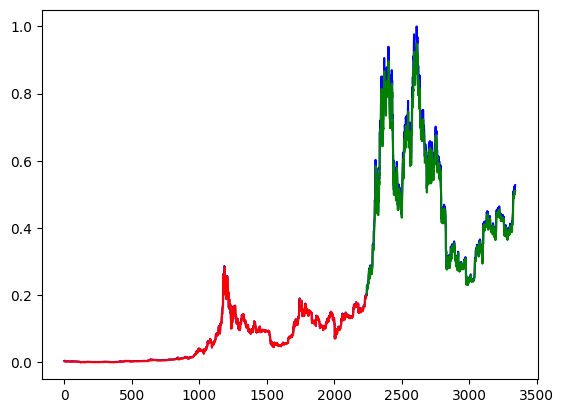

In [ ]:
plot_predictions(best_model, X_train, y_train, X_test, y_test, timeseries, lookback, train_size)

### **RESULTS:**

the best RNN model has the test rmse score of 0.0708

the best LSTM model has the test rmse score of 0.0282

the best GRU model has the test rmse score of 0.0296


REFERENCES:

(CHAT GPT)https://chat.openai.com/